In [76]:
import os
import time
import random
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt

In [77]:
print(f"Is CUDA available: {torch.cuda.is_available()}")
print(f"PyTorch Version: {torch.__version__}")

Is CUDA available: True
PyTorch Version: 1.10.0+cu113


In [78]:
dataset_path = os.path.abspath("dataset")

transforms = tt.Compose([tt.Resize(size=(256, 256)),
                         tt.RandomAffine(degrees=(-90, 90), translate=(0.2, 0.2), shear=(10), scale=(0.6, 1.0)),
                         tt.ColorJitter(brightness=.2, hue=.05),
                         tt.ToTensor(),
                         tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation_transforms = tt.Compose([tt.Resize(size=(256, 256)),
                                    tt.ToTensor(),
                                    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = ImageFolder(os.path.join(dataset_path, "Train"), transforms)
test_dataset = ImageFolder(os.path.join(dataset_path, "Test"), validation_transforms)
validation_dataset = ImageFolder(os.path.join(dataset_path, "Validation"), validation_transforms)

In [79]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, num_workers=0)

In [80]:
label_map = {0: "mask", 1: "no_mask"}

def show_batch(dataloader):
    for images, labels in dataloader:
        fig, axs = plt.subplots(4, int(batch_size/4), constrained_layout=True, dpi=300)

        for (image, label, axs) in zip(images, labels, axs.flatten()):
            axs.imshow(image.permute(1,2,0).clamp(0,1))
            axs.set_title(label_map[label.item()])
            axs.axis('off')
        
        break

    plt.show()

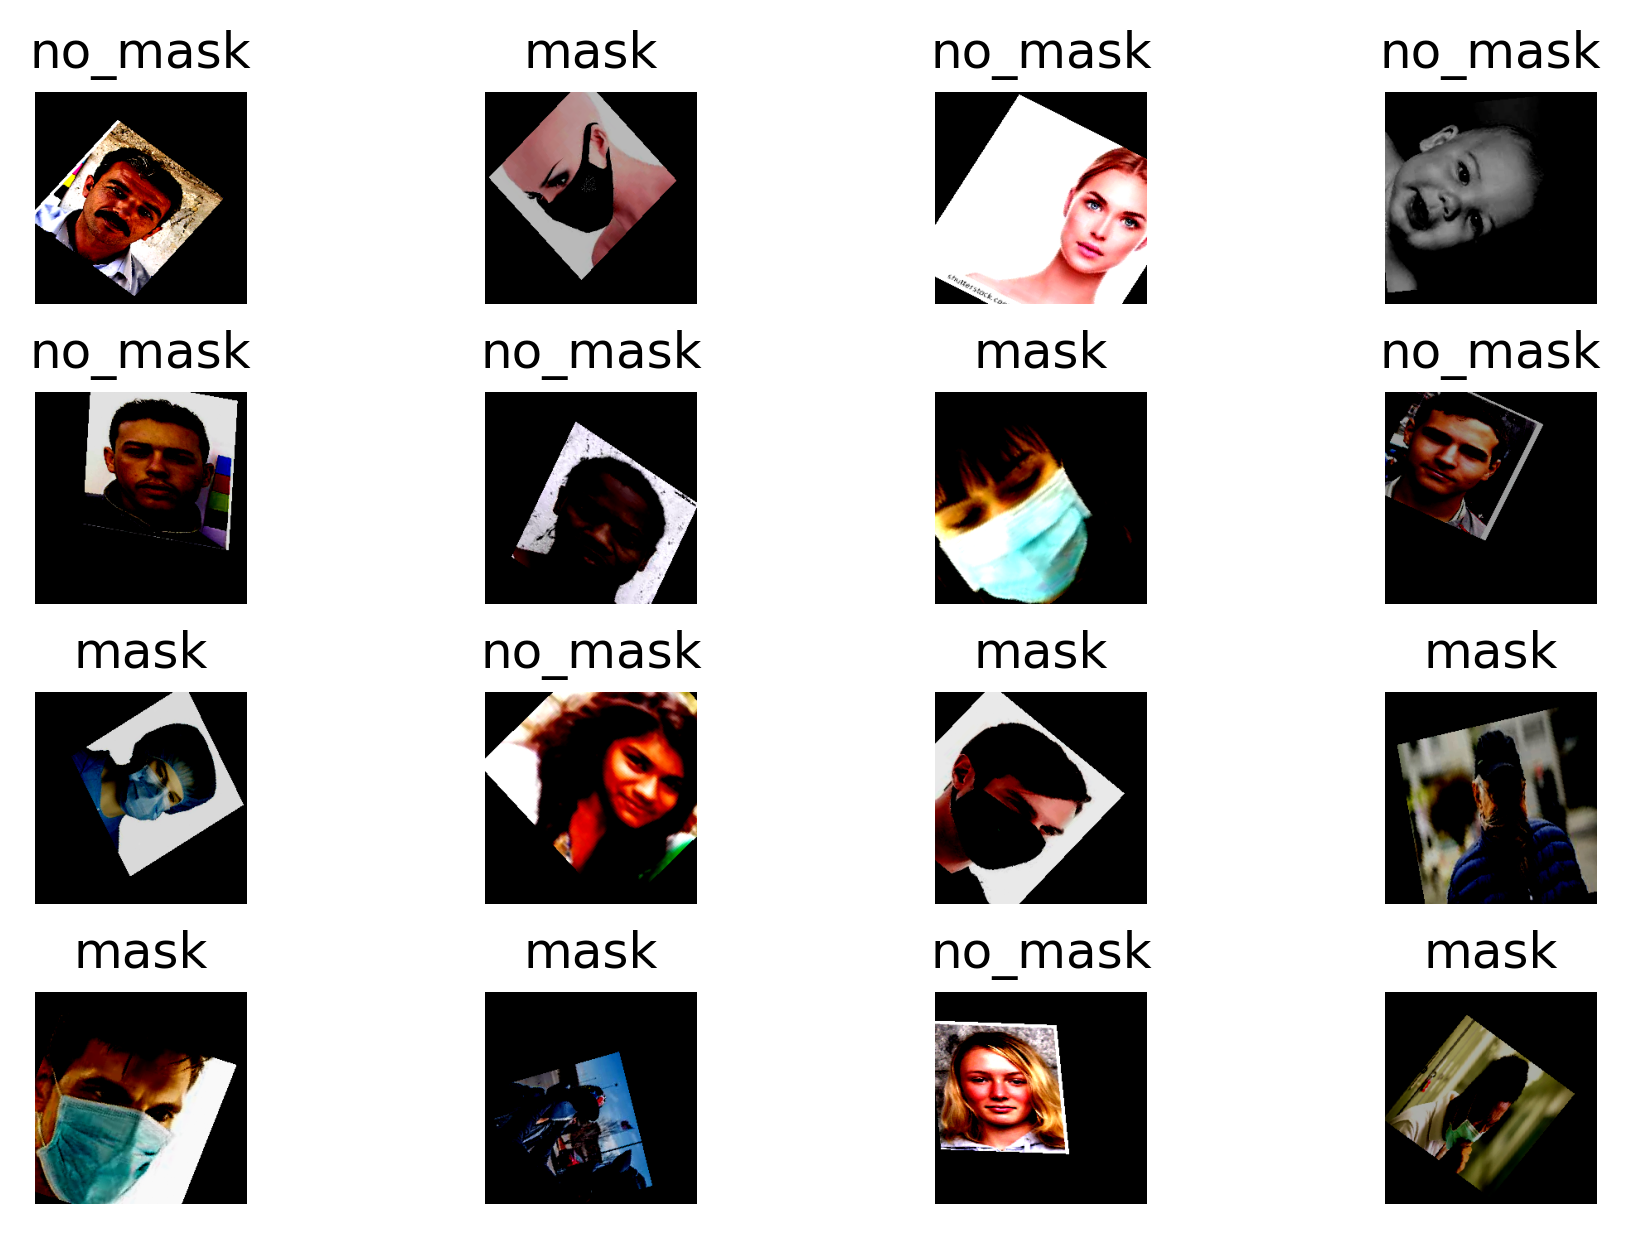

In [81]:
show_batch(train_dataloader)

In [82]:
for images, labels in test_dataloader:
    print(f"Shape of images [N, C, H, W]: {images.shape}")
    print(f"Shape of labels: {labels.shape}, {labels.dtype}")
    break

Shape of images [N, C, H, W]: torch.Size([16, 3, 256, 256])
Shape of labels: torch.Size([16]), torch.int64


In [83]:
class mask_net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(mask_net, self).__init__()

        # input: 3 X 256 x 256
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(4)) # out: 64 x 64 x 64
        
        self.res1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.3),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.3),
                                  nn.ReLU(inplace=True)) # out: 64 x 64 x 64

        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(4)) # out: 64 x 16 x 16
        
        self.res2 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.3),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.3),
                                  nn.ReLU(inplace=True)) # out: 64 x 16 x 16

        self.conv3 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(inplace=True),
                                  nn.AdaptiveAvgPool2d(output_size=1)) # out: 128 x 4 x 4

        self.classifier = nn.Sequential(nn.Flatten(),  # out: 128
                                        nn.Dropout(p=0.5),
                                        nn.Linear(128, 32),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(32, num_classes),
                                        nn.Softmax(dim=1))  # out: 2

    def forward(self, inpt):
        out = self.conv1(inpt)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.classifier(out)
        return out

In [84]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [85]:
model = mask_net(in_channels=3, num_classes=2).to(device)
print(model)

mask_net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Re

In [86]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [87]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [88]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>4f}%, Avg loss: {test_loss:>8f} \n")

In [89]:
epochs = 50

start_time = time.perf_counter()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

time_passed = timedelta(seconds=time.perf_counter() - start_time)

print(f"Done in {time_passed}!")

Epoch 1
-------------------------------
loss: 0.670040  [    0/ 4496]
loss: 0.481290  [ 1600/ 4496]
loss: 0.752547  [ 3200/ 4496]


C:\Users\zakamycze\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Error: 
 Accuracy: 71.162882%, Avg loss: 0.591416 

Epoch 2
-------------------------------
loss: 0.454289  [    0/ 4496]
loss: 0.489622  [ 1600/ 4496]
loss: 0.489317  [ 3200/ 4496]
Test Error: 
 Accuracy: 66.444792%, Avg loss: 0.636935 

Epoch 3
-------------------------------
loss: 0.622265  [    0/ 4496]
loss: 0.433390  [ 1600/ 4496]
loss: 0.319927  [ 3200/ 4496]
Test Error: 
 Accuracy: 74.040720%, Avg loss: 0.565301 

Epoch 4
-------------------------------
loss: 0.608567  [    0/ 4496]
loss: 0.506332  [ 1600/ 4496]
loss: 0.484235  [ 3200/ 4496]
Test Error: 
 Accuracy: 73.727486%, Avg loss: 0.567791 

Epoch 5
-------------------------------
loss: 0.567588  [    0/ 4496]
loss: 0.382934  [ 1600/ 4496]
loss: 0.410831  [ 3200/ 4496]
Test Error: 
 Accuracy: 77.936570%, Avg loss: 0.526400 

Epoch 6
-------------------------------
loss: 0.560821  [    0/ 4496]
loss: 0.450735  [ 1600/ 4496]
loss: 0.423086  [ 3200/ 4496]
Test Error: 
 Accuracy: 80.285826%, Avg loss: 0.506073 

Epoch 7


In [90]:
torch.save(model.state_dict(), "model.pth")
print("Saved net model state to model.pth")

Saved net model state to model.pth


In [29]:
model = mask_net(in_channels=3, num_classes=2)
model.to(device)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load("model.pth", map_location=device))

<All keys matched successfully>

In [30]:
def predict(tensor, model):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tensor = tensor.to(device)
    prediction = model(tensor.unsqueeze(0))
    prediction = prediction.clone().detach()
    return prediction

In [31]:
classes = ["mask", "no_mask"]

model.eval()

rand_number = random.randint(0, len(validation_dataset))
x, y = validation_dataset[rand_number][0], validation_dataset[rand_number][1]

with torch.no_grad():
    pred = predict(x, model)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f"Predicted: \"{predicted}\", Actual: \"{actual}\"")

Predicted: "mask", Actual: "mask"


In [32]:
classes = ["mask", "no_mask"]

def show_validation(images, labels):
    fig, axs = plt.subplots(4, int(batch_size/4), constrained_layout=True, dpi=300)
    
    for (image, label, axs) in zip(images, labels, axs.flatten()):
        axs.imshow(image.permute(1,2,0).clamp(0,1))
        
        with torch.no_grad():
            pred = predict(image, model)
            predicted, actual = classes[pred[0].argmax(0)], classes[label]
            axs.set_title(f"net:{predicted},\nirl: {actual}", fontsize=10)
        
        axs.axis('off')

    plt.show()

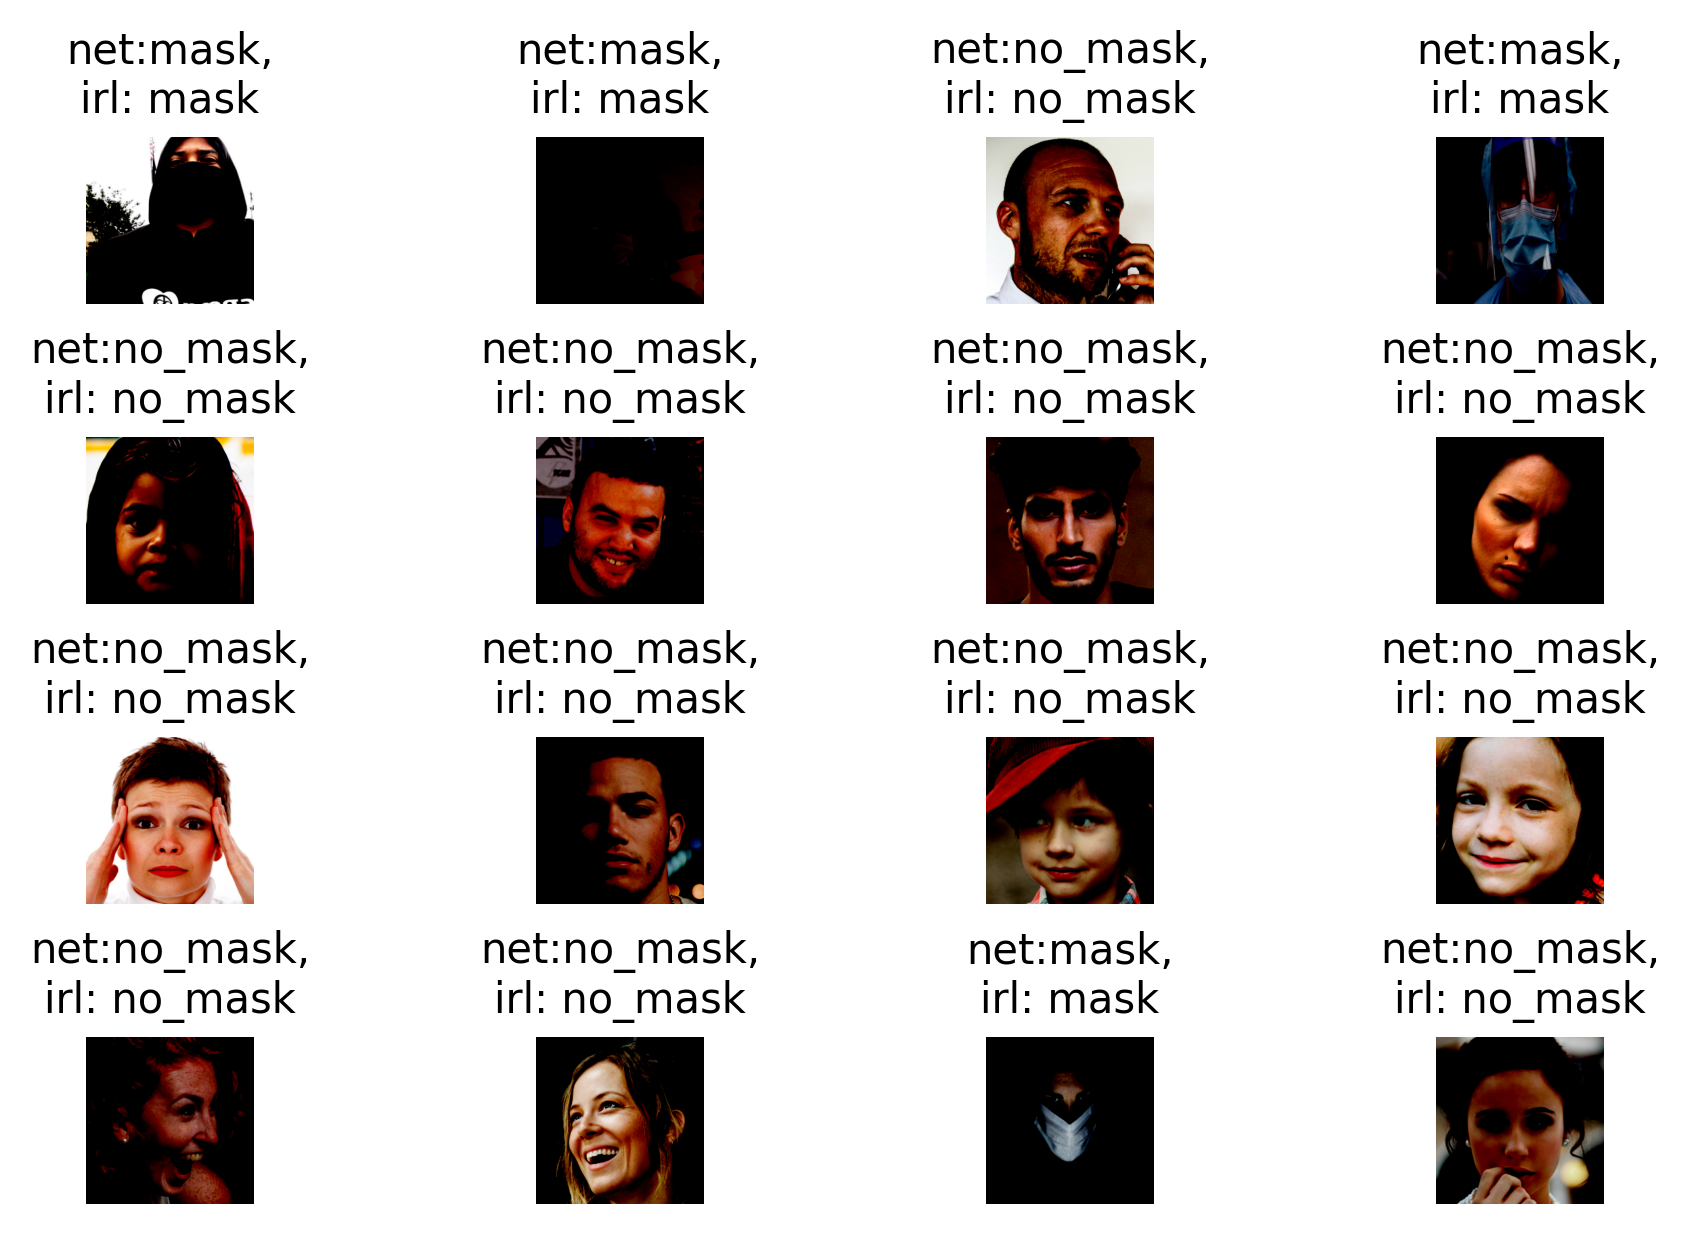

In [33]:
random_nums = [random.randint(0, len(validation_dataset) - 1) for _ in range(batch_size)]
imgs = [validation_dataset[i][0] for i in random_nums]
labls = [validation_dataset[i][1] for i in random_nums]

show_validation(imgs, labls)